In [1]:
# Starter cell: make repo root importable, then run bootstrap
import sys
from pathlib import Path

# If running a notebook inside scripts/, cwd is .../perch-scale-bird-weights/scripts
# -> parent() is the repo root. If your notebooks are deeper, bump parents[2], etc.
ROOT = Path.cwd()
for _ in range(5):       # walk up to 5 levels until we find the repo
    if (ROOT / ".git").exists() or (ROOT / "README.md").exists():
        break
    ROOT = ROOT.parent

if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

# Generate Figure 4 - Overnight weight loss analysis

## Part 1 - core functions and adjustable parameters

In [42]:
# scripts/figures/fig4_overnight_weight_loss.py
from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from pathlib import Path
from sklearn.linear_model import LinearRegression

from scripts import _paths as P
from scripts import helpers  # provides read_timeseries, find_bird_file

# ===================== Adjustable Parameters =====================
START_DATE          = None   # 'YYYY-MM-DD' or None
END_DATE            = None   # 'YYYY-MM-DD' or None
LOW_THRESHOLD       = 1
HIGH_THRESHOLD      = 30
MIN_SEQUENCE_HOURS  = 5
MAX_GAP_SECONDS     = 120
ON_WEIGHT_THRESHOLD = 11
DOWNSAMPLE_STEP     = 5
RAW_FILTER_LOW      = 0.02
RAW_FILTER_HIGH     = 0.98
STD_WINDOW_MINUTES  = 10
CONTEXT_HOURS       = 1
# =================================================================

# ---------- Core utilities tied to repo layout ----------
def load_actual_weight(bird_id: str | int, date_str: str) -> float | None:
    """
    Return the manual weight for a given bird_id and date (YYYY-MM-DD).

    Reads 'data/metadata/daily_manual_weights.csv' with columns:
        bird_id,<date1>,<date2>,...,mean,std

    If the date value is missing or NaN, returns the 'mean' value instead.
    Returns None only if the bird_id or both date and mean are missing.
    """
    path = P.META / "daily_manual_weights.csv"
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")

    # read with bird_id as string index for consistency
    df = pd.read_csv(path, dtype={"bird_id": str}).set_index("bird_id")

    bid = str(bird_id)
    if bid not in df.index:
        return None

    # try to get the date-specific value
    val = None
    if date_str in df.columns:
        val = df.at[bid, date_str]
        if pd.notna(val):
            return float(val)

    # fallback: use mean if available
    if "mean" in df.columns and pd.notna(df.at[bid, "mean"]):
        return float(df.at[bid, "mean"])

    return None



# ---------- Core functions ----------
def load_bird_data(
    bird_id: str | int,
    low_thrd: float = LOW_THRESHOLD,
    high_thrd: float = HIGH_THRESHOLD,
    start_date: str | None = START_DATE,
    end_date: str | None = END_DATE,
    keep_out_of_range: bool = False,
) -> pd.DataFrame:
    fp = helpers.find_bird_file(bird_id)
    df = helpers.read_timeseries(
        fp,
        low_thrd=low_thrd,
        high_thrd=high_thrd,
        start_date=start_date,
        end_date=end_date,
        keep_out_of_range=keep_out_of_range,
    )
    return df.sort_values("Time").reset_index(drop=True)


def find_all_sequences(
    df: pd.DataFrame,
    *,
    on_weight_threshold: float = ON_WEIGHT_THRESHOLD,
    min_sequence_hours: float = MIN_SEQUENCE_HOURS,
    max_gap_seconds: int = MAX_GAP_SECONDS,
):
    d = df.copy()
    d["dt"] = d["Time"].diff().dt.total_seconds().fillna(0)
    d["On"] = d["weight"] > on_weight_threshold
    d["new"] = (d["On"] != d["On"].shift()) | (d["dt"] > max_gap_seconds)
    d["Group"] = d["new"].cumsum()

    meta = (
        d[d["On"]]
        .groupby("Group")
        .agg(start=("Time", "min"), end=("Time", "max"))
        .assign(hours=lambda x: (x["end"] - x["start"]).dt.total_seconds() / 3600)
        .query("hours >= @min_sequence_hours")
        .reset_index()
    )

    seqs = []
    for _, r in meta.iterrows():
        grp = int(r["Group"])
        df_seq = d[(d["Group"] == grp) & d["On"]].copy().reset_index(drop=True)
        seqs.append(
            {"Group": grp, "df": df_seq, "start": r["start"], "end": r["end"], "hours": r["hours"]}
        )
    return seqs


# --- Minimal endpoints helper (local to the fig4 script) ---
def sequence_endpoints(seq: pd.DataFrame, *, edge_avg_pts: int = 100) -> tuple[pd.Timestamp, pd.Timestamp, float, float]:
    """
    Given a single contiguous 'overnight' perching sequence `seq` with columns ['Time','weight'],
    return (start_time, end_time, start_weight, end_weight).

    We compute start/end weights as the mean of the first/last `edge_avg_pts` samples (or fewer if seq is short)
    to reduce noise without doing rolling-stability logic.
    """
    if seq.empty:
        raise ValueError("sequence_endpoints: empty sequence provided")

    st = seq["Time"].iloc[0]
    en = seq["Time"].iloc[-1]

    n = min(edge_avg_pts, len(seq))
    sw = float(seq["weight"].iloc[:n].mean())
    ew = float(seq["weight"].iloc[-n:].mean())
    return st, en, sw, ew


def compute_metrics(seq_dict: dict, bird_id: str | int) -> dict:
    seq = seq_dict["df"]
    st, en, sw, ew = sequence_endpoints(seq, edge_avg_pts=100)
    duration_h = (en - st).total_seconds() / 3600
    # regression on full raw seq
    X = (seq["Time"] - seq["Time"].iloc[0]).dt.total_seconds().values.reshape(-1, 1)
    y = seq["weight"].values
    m = LinearRegression().fit(X, y)
    pred = m.predict(X)
    slope_hr = m.coef_[0] * 3600  # g/h

    total_loss = sw - ew
    actual = load_actual_weight(bird_id, str(st.date()))
    pct = (total_loss / actual * 100) if actual else np.nan
    pct_hr = (slope_hr / actual * 100) if actual else np.nan

    return {
        "bird": bird_id,
        "start_time": st,
        "end_time": en,
        "start_w": sw,
        "end_w": ew,
        "hours": duration_h,
        "total_loss": total_loss,
        "loss_pct": pct,
        "slope_hr": slope_hr,
        "pct_hr": pct_hr,
        "pred": pred,
        "actual_weight": actual,
    }

## Part 2 - generate overnight sequences metadata 

In [58]:
# ── Code cell: Assemble sequences into a DataFrame + save all_recs (no pred) ──
from __future__ import annotations
import json
import pandas as pd
from scripts import _paths as P

# Adjustable parameters (optional)
start_date    = None
end_date      = None
low_threshold = 1
high_threshold= 30

# Canonical bird IDs
bird_ids = ['1','2','3','4','5','6']

rows = []
all_recs = []

for bird in bird_ids:
    df = load_bird_data(
        bird,
        low_thrd=low_threshold,
        high_thrd=high_threshold,
        start_date=start_date,
        end_date=end_date,
    )
    seqs = find_all_sequences(df)
    if not seqs:
        continue

    for i, seq_dict in enumerate(seqs):
        m = compute_metrics(seq_dict, bird)
        rows.append({
            "bird_id":      str(bird),
            "sequence_idx": i,
            "start_time":   seq_dict["start"],
            "end_time":     seq_dict["end"],
            "duration_h":   float(seq_dict["hours"]),
            "start_weight": float(m["start_w"]),
            "end_weight":   float(m["end_w"]),
            "slope_hr":     float(m["slope_hr"]),
            "total_loss":   float(m["total_loss"]),
            "loss_pct":     None if pd.isna(m["loss_pct"]) else float(m["loss_pct"]),
            "pct_hr":       None if pd.isna(m["pct_hr"])   else float(m["pct_hr"]),
            "actual_weight": None if m["actual_weight"] is None else float(m["actual_weight"]),
        })
        # Save full metrics except for pred
        all_recs.append({k: v for k, v in m.items() if k != "pred"})

# --- Save metadata CSV ---
df_sequences = pd.DataFrame(rows).sort_values(["bird_id", "start_time"]).reset_index(drop=True)
out_csv = P.META / "overnight_sequences_metadata-test.csv"
df_sequences.to_csv(out_csv, index=False)
print(f"Saved metadata CSV: {out_csv} ({len(df_sequences)} sequences)")

# --- Save all_recs JSON (metrics only) ---
out_json = P.META / "overnight_sequences_all_recs.json"
with open(out_json, "w", encoding="utf-8") as f:
    json.dump(all_recs, f, ensure_ascii=False, default=str)
print(f"Saved all_recs JSON: {out_json} ({len(all_recs)} records)")


Saved metadata CSV: /Users/yuval/Desktop/Weizmann stuff/bird_scale_experiment_publishing/data/metadata/overnight_sequences_metadata-test.csv (24 sequences)
Saved all_recs JSON: /Users/yuval/Desktop/Weizmann stuff/bird_scale_experiment_publishing/data/metadata/overnight_sequences_all_recs.json (24 records)


In [38]:
# test function 'load_actual_weight'
bird_id = '1'
date_str = '2025-06-17'
actual_weight = load_actual_weight(bird_id, date_str)
print(actual_weight)    

17.95


## Panel A - Single bird overnight example with regression line

Selected bird: ro, sequence index: 5
(353288, 2) (685848, 2) 10 10


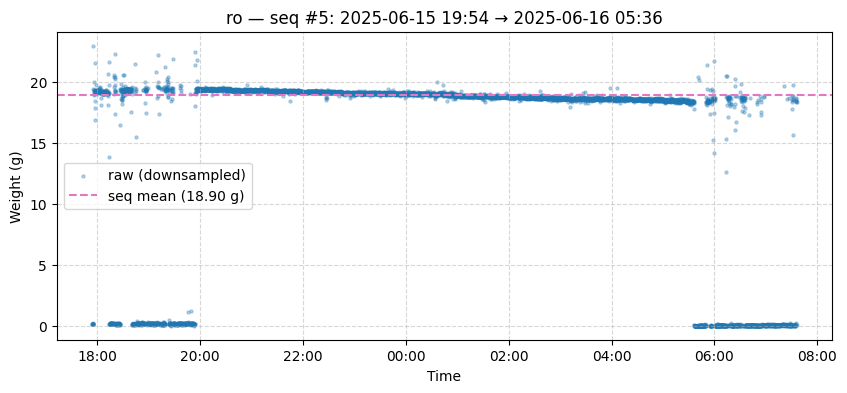

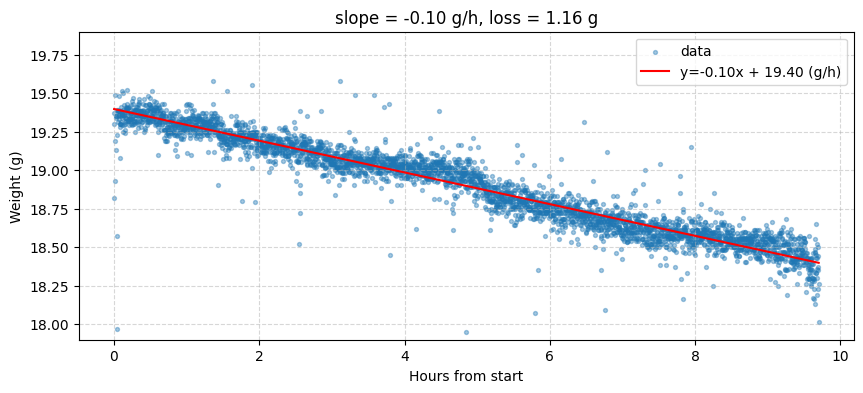

In [5]:
# ── Panel A (A1 + A2): local plotting + run ──
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

from scripts import _paths as P

# ---- local plotting functions ----
def plot_fig1(df, seq, metrics, *, context_hours=2, downsample_step=8):
    start = metrics["start_time"] - pd.Timedelta(hours=context_hours)
    end   = metrics["end_time"]   + pd.Timedelta(hours=context_hours)
    win   = df[(df["Time"] >= start) & (df["Time"] <= end)]
    win_d = win.iloc[::downsample_step].copy()

    seq_mean = seq["weight"].mean()
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.scatter(win_d["Time"], win_d["weight"], s=5, alpha=0.3, label="raw (downsampled)")
    ax.axhline(seq_mean, linestyle="--", lw=1.5, color='tab:pink', label=f"seq mean ({seq_mean:.2f} g)")
    ax.set_xlabel("Time"); ax.set_ylabel("Weight (g)")
    ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))
    ax.legend(loc="best"); ax.grid(True, ls="--", alpha=0.5)
    return fig, ax

def plot_fig2(seq, metrics, *, downsample_step=8, raw_filter_low=0.001, raw_filter_high=0.999):
    down = seq.iloc[::downsample_step].copy()
    ql, qh = down["weight"].quantile(raw_filter_low), down["weight"].quantile(raw_filter_high)
    down = down[(down["weight"] >= ql) & (down["weight"] <= qh)].reset_index(drop=True)

    hours_down = (down["Time"] - seq["Time"].iloc[0]).dt.total_seconds() / 3600
    hours_full = (seq["Time"] - seq["Time"].iloc[0]).dt.total_seconds() / 3600
    pred_interp = np.interp(hours_down, hours_full, metrics["pred"])

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.scatter(hours_down, down["weight"], s=8, alpha=0.4, label="data")
    ax.plot(hours_down, pred_interp, lw=1.5, color='red', label=f"y={metrics['slope_hr']:.2f}x + {pred_interp[0]:.2f} (g/h)")
    seq_mean = seq["weight"].mean()
    ax.set_ylim(seq_mean - 1, seq_mean + 1)
    ax.set_xlabel("Hours from start"); ax.set_ylabel("Weight (g)")
    ax.legend(); ax.grid(True, ls="--", alpha=0.5)
    return fig, ax

# ---- run Panel A ----
P.FIGS.mkdir(parents=True, exist_ok=True)

df_sequences = pd.read_csv(P.META / "overnight_sequences_metadata.csv",
                           parse_dates=["start_time", "end_time"])

selection_index = 5  # ← change to choose sequence
row     = df_sequences.iloc[selection_index]
bird = row["bird"]
bird_id = int(row["bird_id"]) 
seq_idx = int(row["sequence_idx"])
downsample_step = 8

# assumes previous cell defined: load_bird_data, find_all_sequences, compute_metrics
df_filtered   = load_bird_data(bird_id, low_thrd=1, high_thrd=30)
df_unfiltered = load_bird_data(bird_id, low_thrd=0, high_thrd=30)
seqs = find_all_sequences(df_filtered)
mets = [compute_metrics(sd, bird_id) for sd in seqs]

print(f"Selected bird: {bird}, sequence index: {seq_idx}")
print(df_filtered.shape, df_unfiltered.shape, len(seqs), len(mets))

# A1
fig1, ax1 = plot_fig1(df_unfiltered, seqs[seq_idx]["df"], mets[seq_idx],
                      downsample_step=downsample_step, context_hours=2)
ax1.set_title(f"{bird} — seq #{seq_idx}: "
              f"{row['start_time']:%Y-%m-%d %H:%M} → {row['end_time']:%Y-%m-%d %H:%M}")
# fig1.savefig(P.FIGS / "overnight_panel_A1.svg", bbox_inches="tight", dpi=300)

# A2
fig2, ax2 = plot_fig2(seqs[seq_idx]["df"], mets[seq_idx],
                      downsample_step=downsample_step, raw_filter_low=0.001, raw_filter_high=0.999)
ax2.set_title(f"slope = {mets[seq_idx]['slope_hr']:.2f} g/h, loss = {mets[seq_idx]['total_loss']:.2f} g")
# fig2.savefig(P.FIGS / "overnight_panel_A2.svg", bbox_inches="tight", dpi=300)

plt.show()


## Panel B - summary of all overnight sequences from 5 birds + Global fit line

/var/folders/zn/pz4kcssx25z7qv97tn7_41t00000gn/T/ipykernel_37467/876694541.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(birds))


Saved: /Users/yuval/Desktop/Weizmann stuff/bird_scale_experiment_publishing/figures/overnight_panel_C.svg


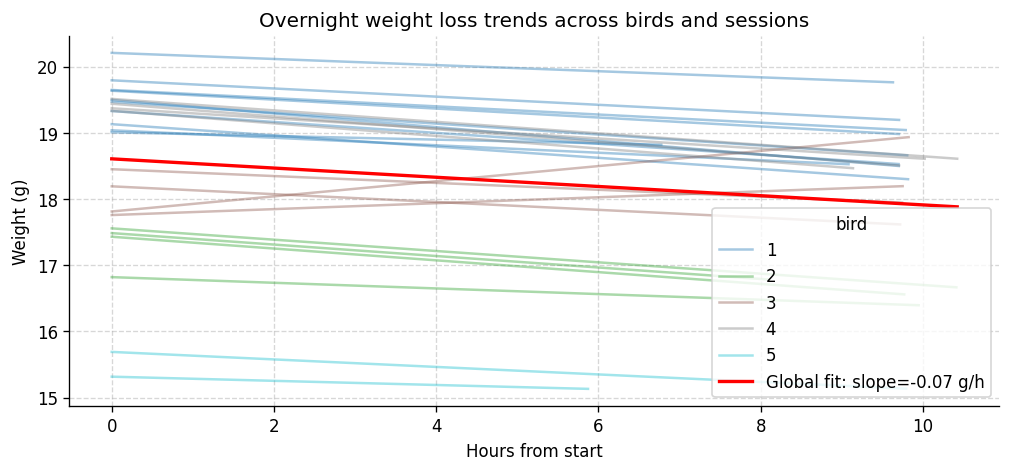

In [59]:
# --- Multi-bird trajectories from saved all_recs (JSON; no regen) ---

import json
import numpy as np
import matplotlib.pyplot as plt
from scripts import _paths as P

# 1) Load metrics-only all_recs (no 'pred')
with open(P.META / "overnight_sequences_all_recs.json", "r", encoding="utf-8") as f:
    all_recs_saved = json.load(f)

# 2) Rebuild `records` expected by plot_fig3 by regenerating a simple linear `pred`
records = []
n_pred = 200
for m in all_recs_saved:
    bird = str(m["bird"])
    hours = float(m["hours"])
    start_w = float(m["start_w"])
    slope_hr = float(m["slope_hr"])
    t = np.linspace(0, hours, n_pred)
    pred = start_w + slope_hr * t
    records.append({"bird": bird, "hours": hours, "pred": pred, "slope_hr": slope_hr})

# 3) Your original plotting function (unchanged; safe colormap handling)
def plot_fig3(records, show_per_bird_avg=True):
    """
    Plots each bird’s regression trajectory.
    If show_per_bird_avg is True, shows the average line per bird.
    If False, shows all individual lines.
    The global regression fit (red) is computed only from sequences with negative slopes.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(10,4))
    birds = sorted({r['bird'] for r in records})

    # safe color mapping using tab10
    cmap = plt.cm.get_cmap("tab10", len(birds))
    color_map = dict(zip(birds, [cmap(i) for i in range(len(birds))]))

    all_hours, all_vals = [], []
    neg_hours, neg_vals = [], []

    if show_per_bird_avg:
        # Plot average line per bird
        for bird in birds:
            bird_recs = [r for r in records if r['bird'] == bird]
            max_h = max(r['hours'] for r in bird_recs)
            common_hrs = np.linspace(0, max_h, 200)
            interp_preds = []
            for r in bird_recs:
                hrs = np.linspace(0, r['hours'], len(r['pred']))
                interp = np.interp(common_hrs, hrs, r['pred'])
                interp_preds.append(interp)
                all_hours.append(hrs)
                all_vals.append(r['pred'])
                # Only use negative slopes for global fit
                if r['slope_hr'] < 0:
                    neg_hours.append(hrs)
                    neg_vals.append(r['pred'])
            mean_pred = np.mean(interp_preds, axis=0)
            ax.plot(common_hrs, mean_pred, color=color_map[bird], label=bird)
    else:
        # Plot all individual lines
        birds_plotted = set()
        for r in records:
            hrs = np.linspace(0, r['hours'], len(r['pred']))
            bird = r['bird']
            label = bird if bird not in birds_plotted else None
            ax.plot(hrs, r['pred'], color=color_map[bird], alpha=0.4, label=label)
            birds_plotted.add(bird)
            all_hours.append(hrs)
            all_vals.append(r['pred'])
            # Only use negative slopes for global fit
            if r['slope_hr'] < 0:
                neg_hours.append(hrs)
                neg_vals.append(r['pred'])
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), title='bird')

    # Global fit: average slope & intercept among negative-slope sequences
    if any(r['slope_hr'] < 0 for r in records):
        slopes = [r['slope_hr'] for r in records if r['slope_hr'] < 0]
        intercepts = [r['pred'][0]   for r in records if r['slope_hr'] < 0]
        avg_slope = float(np.mean(slopes))
        avg_intercept = float(np.mean(intercepts))

        max_h = max([r['hours'] for r in records])
        common_hrs = np.linspace(0, max_h, 200)
        fit_vals = avg_slope * common_hrs + avg_intercept

        ax.plot(common_hrs, fit_vals,
                color='red', linewidth=2,
                label=f'Global fit: slope={avg_slope:.2f} g/h')

    ax.set_xlabel('Hours from start')
    ax.set_ylabel('Weight (g)')
    ax.legend(title='bird')
    ax.grid(True, ls='--', alpha=0.5)
    return fig, ax

# 4) Render + save (same output path as before)
if records:
    fig3, ax3 = plot_fig3(records, show_per_bird_avg=False)
    ax3.set_title("Overnight weight loss trends across birds and sessions")
    out = P.FIGS / "overnight_panel_C.svg"
    fig3.savefig(out, bbox_inches='tight', dpi=300, format='svg')
    print(f"Saved: {out}")
    plt.show()
else:
    print("No records found in overnight_sequences_all_recs.json.")
